In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, make_scorer, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

from app.functions.process_url import *


# Dataset loading and creating features

In [2]:
data = pd.read_csv('../data/dataset_url.csv')

features = data['url'].apply(extract_features)

data = pd.concat([data, features], axis=1)
data.drop('url', axis=1, inplace=True)
# changing labels to numeric format
data.loc[data['label'] == 'bad', 'label'] = 1
data.loc[data['label'] == 'good', 'label'] = 0
data['label'] = data['label'].astype(int)


In [3]:
print(data.head())

   label  NumDots  PathLevel  UrlLength  NumDash  NumDashInHostname  AtSymbol  \
0      1        1          0         22        0                  0     False   
1      1        2          0         16        0                  0     False   
2      1        1          0         18        0                  0     False   
3      1        1          0         13        0                  0     False   
4      1        1          0         21        0                  0     False   

   TildeSymbol  NumUnderscore  NumUnderscoreInHostname  ...  \
0        False              0                        0  ...   
1        False              0                        0  ...   
2        False              0                        0  ...   
3        False              0                        0  ...   
4        False              0                        0  ...   

   PresenceSpecificTLDs  CountSensitiveWords  ProportionAlphaChars  \
0                 False                    0              0.9545

# Exploratory data analysis

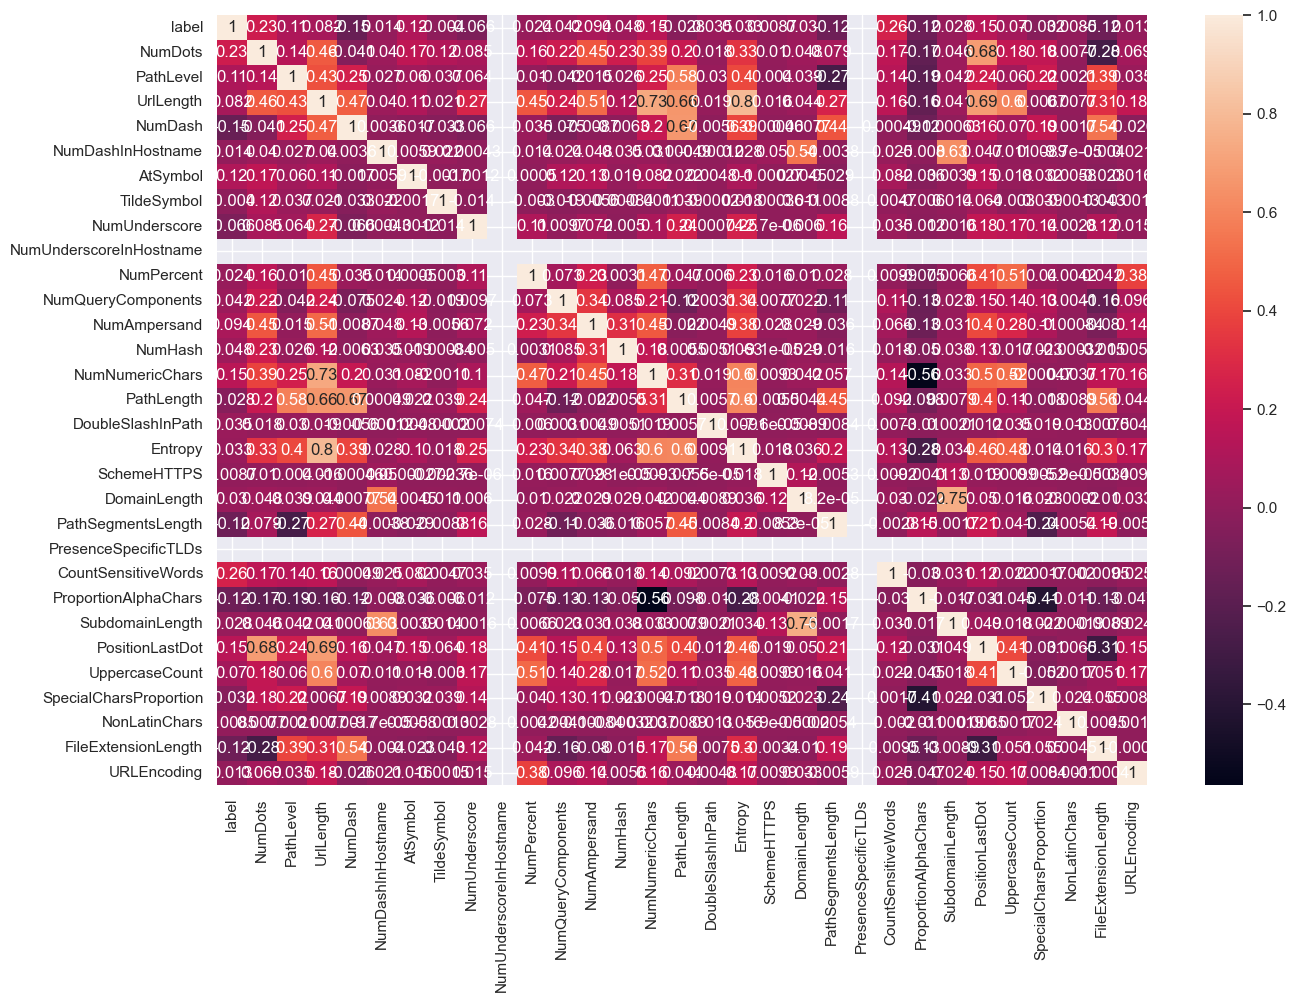

In [4]:
#Features correlation plot
sns.set(rc={'figure.figsize': (15, 10)})
sns.heatmap(data.corr(), annot=True)
plt.show()


In [4]:
# class inbalance check
print(len(data[data['label']==1]))
print(len(data[data['label']==0]))


75643
344821


# Training models

In [5]:
def oversample_minority_class(x, y):
    minority_class = y.value_counts().idxmin()
    num_samples_minority = y.value_counts().max() - y.value_counts().min()

    minority_indices = y[y == minority_class].index
    random_indices = np.random.choice(minority_indices, size=num_samples_minority, replace=True)

    x_oversampled = pd.concat([x, x.loc[random_indices]], ignore_index=True)
    y_oversampled = pd.concat([y, y.loc[random_indices]], ignore_index=True)

    return x_oversampled, y_oversampled


In [6]:
X = data.drop(['label'], axis=1)
y = data['label']
major_classs= np.argmax([len(y[y==cl]) for cl in np.unique(y)])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)


# Resample the training data
X_train, y_train = oversample_minority_class(X_train, y_train)

# choosing possible hyperparameters for each model
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}

param_grid_lr = {
    'C': [3],
    'solver': ['liblinear', 'saga']
}

param_grid_dt = {
    'max_depth': [20, None],
    'min_samples_split': [10, 20]
}

param_grid_knn = {
    'n_neighbors': [5, 11],
    'weights': ['distance']
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, None],
    'learning_rate': [0.01],
    'subsample': [0.6, 0.8],
    'min_child_weight': [1, 3, 5]
}


# Initialize models with GridSearchCV
models = {
    'Random Forest': GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5,n_jobs=-1),
    'Logistic Regression': GridSearchCV(LogisticRegression(), param_grid_lr, cv=5,n_jobs=-1),
    'Decision Tree': GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5,n_jobs=-1),
    'XGBoost': GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, n_jobs=-1)
    #'KNN': GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5,n_jobs=-1)
}


best_models = {}
validation_results = {}

#TODO wybrałem recall jako główne kryterium ponieważnaj ważniejsze żeby wyłapać jak najwięcej złych linków False Positive<False negative

for model_name, model in models.items():
    model.fit(X_train, y_train)
    best_models[model_name] = model.best_estimator_
    y_val_pred = model.predict(X_test)
    recall = recall_score(y_test, y_val_pred)
    
    validation_results[model_name] = recall
    print(f"{model_name} best parameters: {model.best_params_}")
    print(f"{model_name} validation recall score: {recall}")







Random Forest best parameters: {'max_depth': None, 'n_estimators': 50}
Random Forest validation recall score: 0.8089719296699422
Logistic Regression best parameters: {'C': 3, 'solver': 'liblinear'}
Logistic Regression validation recall score: 0.7289031860044948
Decision Tree best parameters: {'max_depth': None, 'min_samples_split': 10}
Decision Tree validation recall score: 0.7852641783809986
XGBoost best parameters: {'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}
XGBoost validation recall score: 0.8475741418058432



# bez dodatkowych featureas
Random Forest best parameters: {'max_depth': None, 'n_estimators': 100} n
Random Forest validation recall score: 0.7905080861939805
Logistic Regression best parameters: {'C': 3, 'solver': 'liblinear'}
Logistic Regression validation recall score: 0.6639492354470542
Decision Tree best parameters: {'max_depth': None, 'min_samples_split': 10}
Decision Tree validation recall score: 0.7782576124796192

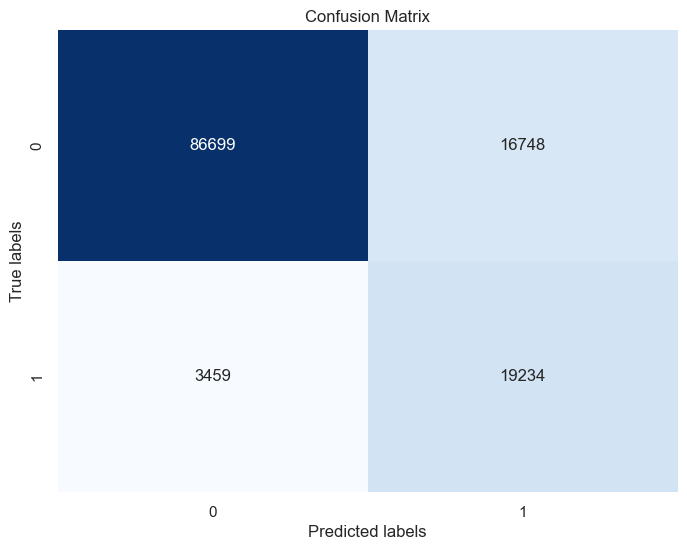

In [7]:
# confusion matrix of best model
model=best_models['XGBoost']
y_test_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
